# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import math

import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torchvision import datasets, transforms

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import compute_linear_velocity_batch, forward_euler_integration_analytic_linear, compute_predictions
from sine_funcs import visualize_sine_trajectory, sine_trajectory_animation

os.makedirs("results", exist_ok=True)

# Set device (automatically detects GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Load Dataset

In [2]:
import random

# Dataset Path
dataset_path = Path("datasets/sine_dataset")
# Load all samples
sample_files = sorted(dataset_path.glob("sample_*.npy"))
if not sample_files:
    raise FileNotFoundError(f"No samples found in {dataset_path}")

# Stack and convert into tensor
samples = np.stack([np.load(f) for f in sample_files])
sine_data = torch.from_numpy(samples).float()

print(f"Loaded sine dataset shape: {sine_data.shape}")

num_noise_samples = 3
noise_samples = torch.randn_like(sine_data[:num_noise_samples])
print(f"Generated noise samples shape: {noise_samples.shape}")

##
training_data = sine_data

Loaded sine dataset shape: torch.Size([500, 1000])
Generated noise samples shape: torch.Size([3, 1000])


## Visualize Dataset

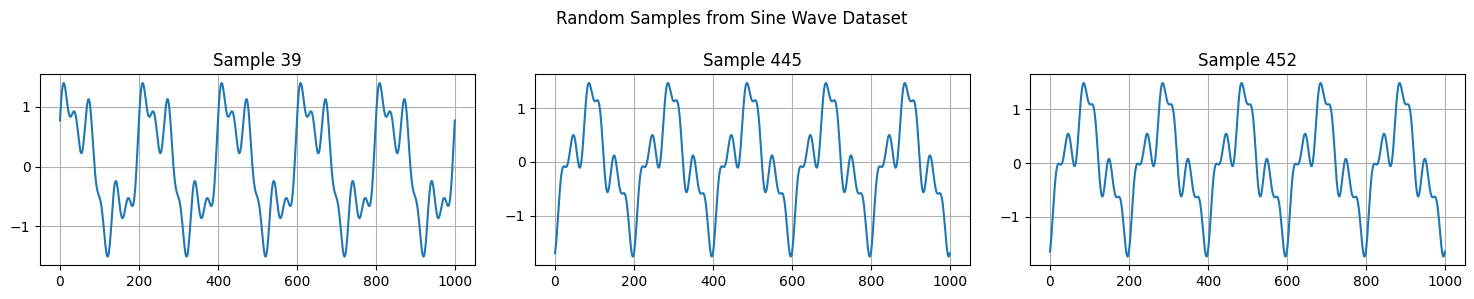

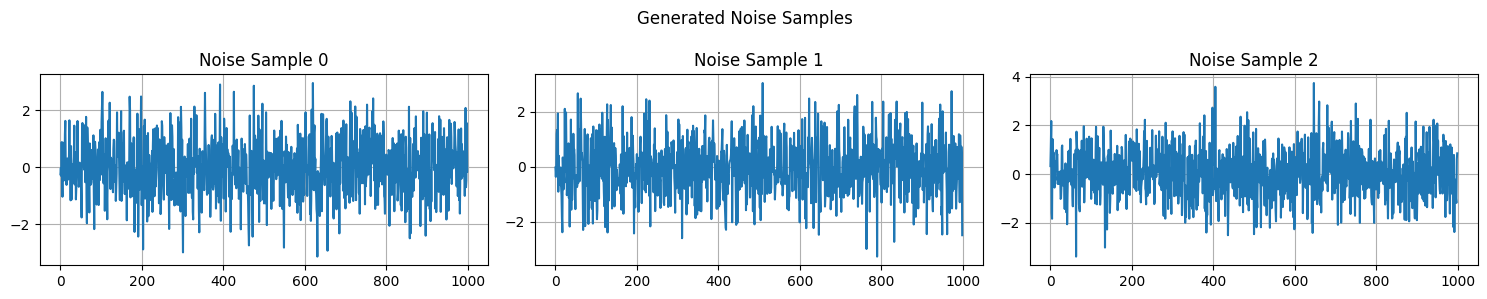

In [3]:
## Plotting random samples
n_samples = 3
plt.figure(figsize=(15, 3))
# Select random samples
indices = random.sample(range(len(samples)), n_samples)
for i, idx in enumerate(indices):
    plt.subplot(1, n_samples, i+1)
    plt.plot(training_data[idx].numpy())
    plt.title(f"Sample {idx}")
    plt.grid(True)
plt.suptitle("Random Samples from Sine Wave Dataset")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 3))
for i, noise in enumerate(noise_samples):
    plt.subplot(1, n_samples, i+1)
    plt.plot(noise.numpy())
    plt.title(f"Noise Sample {i}")
    plt.grid(True)

plt.suptitle("Generated Noise Samples")
plt.tight_layout()
plt.show()

# Analytic Flow-Matching

In [4]:
# Run integration
start_time = time.time()
num_steps = 50

print (noise_samples.shape)
print (training_data.shape)

trajectory = forward_euler_integration_analytic_linear(
    initial_points=noise_samples,
    data=training_data,
    t_start=0.0,
    t_end=1.0, 
    num_steps=num_steps,
    sigma_i=1.0
)

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Integration completed in {elapsed_time:.4f} seconds")

torch.Size([3, 1000])
torch.Size([500, 1000])
Integration completed in 0.1176 seconds


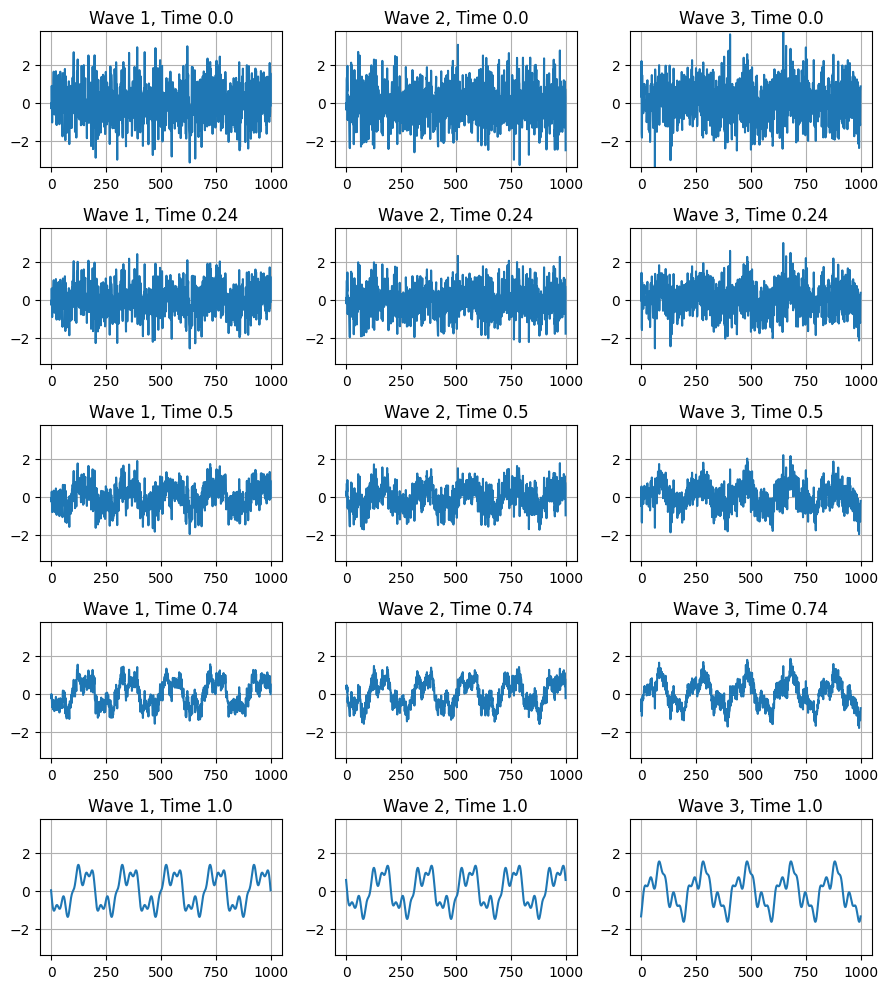

In [5]:
visualize_sine_trajectory(trajectory, num_time_points=5)

In [6]:
ani = sine_trajectory_animation(trajectory)
ani.save('results/sine_analytic_denoising.gif', writer='pillow', fps=20, dpi=80)

# To display in Jupyter notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

torch.Size([51, 3, 1000])


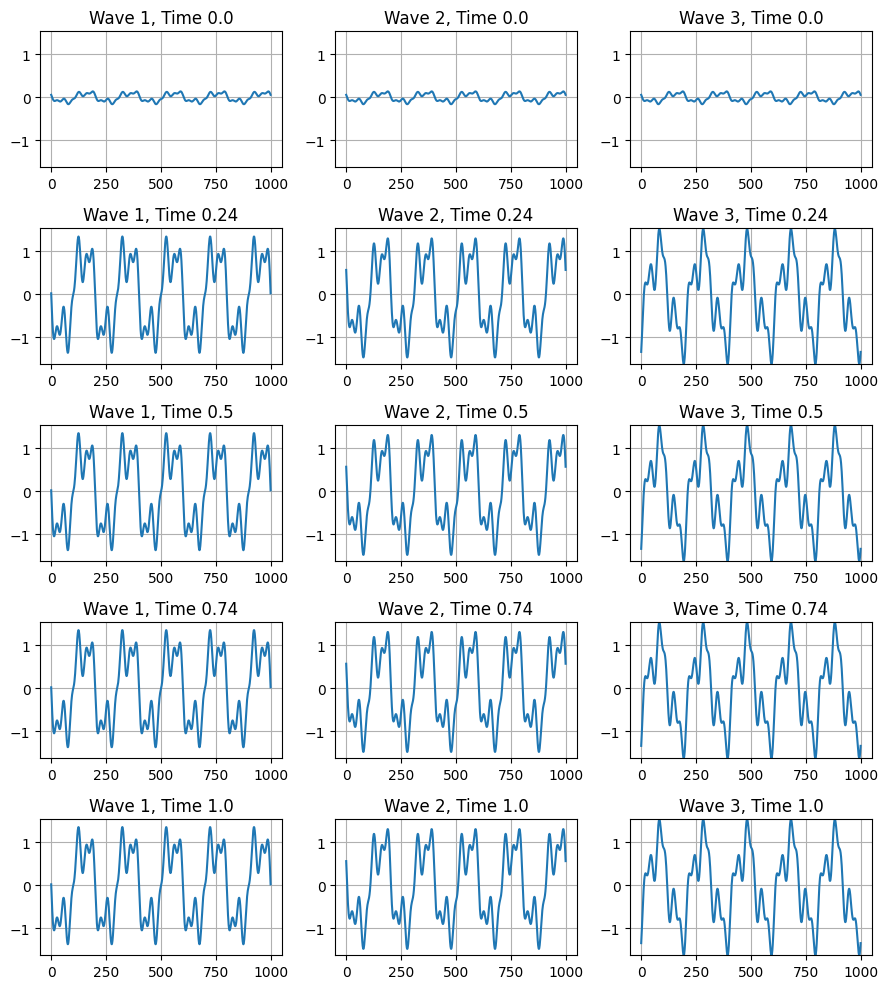

In [7]:
predictions = compute_predictions(trajectory, num_steps=num_steps)
visualize_sine_trajectory(predictions, num_time_points=5)  # Show time points